In [9]:
import pandas as pd
import numpy as np


all_data = pd.read_csv('/home/abdelrahman.sadallah/mbzuai/review_rewrite/data/all_review_points.csv')

In [10]:

### remove the taken examples: 
taken = pd.read_csv(f'../data/taken_for_human_data/taken_1k_samples_human_annotation_sampled.csv')['point']
taken  = pd.concat([taken, pd.read_csv(f'../data/human_annotation_gathered/all_human_annotations_processed.csv')['review_point']])
taken = pd.concat([taken, pd.read_csv(f'../data/taken_for_human_data/filtered_samples.csv')['point']])
print(len(all_data))
## remove the taken samples from all
all_data = all_data[~all_data['point'].isin(taken)]
len(all_data)


207187


204917

In [11]:
all_data.columns

Index(['paper_id', 'venue', 'focused_review', 'point'], dtype='object')

In [12]:
def filter_bad_points(point):
    ## remove the points that have less than 5 words
    ## remove points that ends in ; or :
    ## remove points that starts with . or + 
    ## remove points that has avg word length less than 4
    ## if the word "Strengths" is in the first few words
    ## if @ in in the begining of the first few words

    point = point['point']
    if len(point.split()) < 5:
        return False
    if point[-1] in [';', ':']:
        return False
    if point[0] in ['.', '+', '@']:
        return False
    if np.mean([len(w) for w in point.split()]) < 4:
        return False
    first_5 = point.split()[:5]
    for w in first_5:
        if 'strength' in w.lower():
            return False
        if 'recommndation' in w.lower():
            return False
        if '@' in w:
            return False

    
    return True
    

In [13]:
## iterate over the points and filter the bad ones
all_data = all_data[all_data.apply(filter_bad_points, axis=1)]


In [14]:
len(all_data)

193998

# Chatgpt filteration


In [15]:
# Total number of samples
total_samples = 12000

# Uniform sampling
grouped = all_data.groupby("venue")
samples_per_group = max(1, total_samples // grouped.ngroups)  # Divide total_samples evenly
sampled_df = (
    grouped.apply(lambda group: group.sample(n=min(len(group), samples_per_group), random_state=42))
    .reset_index(drop=True)
)

# If more rows are still needed due to rounding, sample the remainder
remainder = total_samples - len(sampled_df)
if remainder > 0:
    remaining_sample = all_data.loc[~all_data.index.isin(sampled_df.index)].sample(n=remainder, random_state=42)
    sampled_df = pd.concat([sampled_df, remaining_sample]).reset_index(drop=True)

print(sampled_df.value_counts("venue"))

sampled_df['id'] = range(1, len(sampled_df) + 1)
sampled_df.to_csv(f'/home/abdelrahman.sadallah/mbzuai/review_rewrite/chatgpt/main_data/unfiltered_main_chatgpt_data.csv', index=False)

/tmp/ipykernel_3155991/2290027933.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped.apply(lambda group: group.sample(n=min(len(group), samples_per_group), random_state=42))


venue
ICLR_2025     2932
ICLR_2024     1924
EMNLP_2023    1027
NIPS_2020      953
ARR_2022       857
ICLR_2022      857
ICLR_2023      857
NIPS_2018      666
NIPS_2022      523
ACL_2017       395
ICLR_2021      380
NIPS_2019      310
NIPS_2021      239
NIPS_2017       80
Name: count, dtype: int64


In [16]:
# path = '/home/abdelrahman.sadallah/mbzuai/review_rewrite/data/taken_for_human_data/filtered_samples.csv'

# unfiltered_data = pd.read_csv(path)
# ### get rows that has the human_difficulty column as 1
# unfiltered_data = unfiltered_data[unfiltered_data['human_discard'] == 1]
# unfiltered_data.to_csv(f'/home/abdelrahman.sadallah/mbzuai/review_rewrite/chatgpt/main_data/discarded_by_human.csv', index=False)

In [17]:
# path = '/home/abdelrahman.sadallah/mbzuai/review_rewrite/chatgpt/main_data/discarded_by_human.csv'
# unfiltered_data = pd.read_csv(path)

# unfiltered_data = unfiltered_data[unfiltered_data.apply(filter_bad_points, axis=1)]
# before_len = len(unfiltered_data)
# after_len = len(unfiltered_data)


In [18]:
PROMPT = '''Evaluate the following review point and determine if it should be discarded based on these criteria:

**discard the point if:**
- It is incomplete or cut off.
- It highlights a strength or positive aspect of the paper.
- It's just some typo fixes. 
- It does not address a limitation or weakness of the paper.
- if the whole point is just mentions of some references.
**Output "1" for dicarded points and "0" for accepted points.**
**Review Point:**
{point}
'''



In [20]:
import pandas as pd
from openai import OpenAI, AsyncOpenAI
import os
import dotenv
import json
dotenv.load_dotenv()
from prompt import *
client = OpenAI(api_key=os.environ.get("review_evaluation_mbzuai"))

model_name = 'gpt-4o'
path = '/home/abdelrahman.sadallah/mbzuai/review_rewrite/chatgpt/main_data/unfiltered_main_chatgpt_data.csv'
unfiltered_data = pd.read_csv(path)

print(len(unfiltered_data))

12000


In [21]:
lines = []

for i,row in unfiltered_data.iterrows():
    review_point = row['point']
    prompt = PROMPT.format(point=review_point)  
    line = {
        "custom_id": f"{row['id']}", 
        "method": "POST", 
        "url": "/v1/chat/completions", 
        "body": {"model": model_name,
        ########### UNCOMMENT AGAIN #########
        # "response_format" :{ "type": "json_object" },
        "temperature": 0,
        "messages": 
        [{"role": "user", "content": prompt}],}}
    lines.append(line)

print(f'sample of the prompts is {lines[0]}')

### Write batch input file
batch_file_path = f"main_data/main_chatgpt_data_unfiltered_batch_input.jsonl"
with open(batch_file_path, 'w') as f:
    for l in lines:
        json.dump(l, f)
        f.write('\n')

### upload the batch file
batch_input_file = client.files.create(
file=open(batch_file_path, "rb"),
purpose="batch")

### create the batch request
batch_input_file_id = batch_input_file.id
batch_data = client.batches.create(
    input_file_id=batch_input_file_id,
    endpoint="/v1/chat/completions",
    completion_window="24h",
    metadata={
        "description": f"batch file for  main chatgpt unfiltered data of 15k model gpt-4o, temperature 0"
    })
batch_metadata = {
    "batch_id": batch_data.id,
    "data_pth": path,
    "batch_input_file_id": batch_input_file_id,
    "batch_file_path": batch_file_path
}

with open(f"main_data/main_chatgpt_data_unfiltered_batch_input_meta_data.json", 'w') as f:
    json.dump(batch_metadata, f, indent=4)
print(f"Batch file for main chatgpt unfiltered data of 15k model gpt-4o, temperature 0 is created with id {batch_data.id}")



sample of the prompts is {'custom_id': '1', 'method': 'POST', 'url': '/v1/chat/completions', 'body': {'model': 'gpt-4o', 'temperature': 0, 'messages': [{'role': 'user', 'content': 'Evaluate the following review point and determine if it should be discarded based on these criteria:\n\n**discard the point if:**\n- It is incomplete or cut off.\n- It highlights a strength or positive aspect of the paper.\n- It\'s just some typo fixes. \n- It does not address a limitation or weakness of the paper.\n- if the whole point is just mentions of some references.\n**Output "1" for dicarded points and "0" for accepted points.**\n**Review Point:**\n6) 279: add "be"7) l. 352: give an example of a nontrivial internal path.\n'}]}}
Batch file for main chatgpt unfiltered data of 15k model gpt-4o, temperature 0 is created with id batch_67add443e26c8190a6d82c9a0b19e24b


In [30]:
def retrive_batch_and_save_results(batch_data):
    
    batch_id = batch_data['batch_id']
    output_file_id = client.batches.retrieve(batch_id).output_file_id
    chatgpt_response =  client.files.content(output_file_id)
    file_path = f"main_data/main_chatgpt_data_unfiltered_batch_output.jsonl"
    with open(file_path, 'w') as file:
        file.write(chatgpt_response.text + '\n')

def save_results(batch_data):
    errors = 0
    chatgpt_response = pd.read_json(f"main_data/main_chatgpt_data_unfiltered_batch_output.jsonl", lines=True)

    # raw_data_df = pd.read_csv(path)
    raw_data_df = unfiltered_data.copy()
    ones = 0

    ### iterate over the review_points in the raw dataframe and make sure they are aligned with the chatgpt input data
    final_df = []
    for i in range(raw_data_df.shape[0]):

        ## try to load the answer as a json object
        try:
            id = raw_data_df.iloc[i]['id']
            chatgpt_row = chatgpt_response[chatgpt_response['custom_id']==id]
            chatgpt_row = chatgpt_row.iloc[0].copy()
            answer = chatgpt_row['response']['body']['choices'][0]['message']['content']
            ## assert that the answer is  0 or 1
            assert answer in ['0', '1']
            if answer == '1':
                ones += 1
            row = raw_data_df.iloc[i].copy()
            row [f'chatgpt_discard'] = answer
            final_df.append(row)
        except:
            errors += 1
            print("No valid JSON found.")
            continue
    print(f"Errors: {errors}")
    print(f"Total ones: {ones}")
    final_df = pd.DataFrame(final_df)
    final_df.to_csv(f"/home/abdelrahman.sadallah/mbzuai/review_rewrite/chatgpt/main_data/human_chatgpt_filtered_data.csv", index=False)

    print(f"Final data size is {len (final_df[final_df['chatgpt_discard']=='0'])}")

In [31]:
import os
import json

batch_data = json.load(open(f'main_data/main_chatgpt_data_unfiltered_batch_input_meta_data.json'))

if client.batches.retrieve(batch_data['batch_id']).status == 'completed':
    print(f"Batch file for main chatgpt data is completed")
    retrive_batch_and_save_results(batch_data)
    save_results(batch_data)
else:
    print(f"Batch file for main chatgpt data is not completed yet")



Batch file for main chatgpt data is completed
No valid JSON found.
No valid JSON found.
No valid JSON found.
No valid JSON found.
No valid JSON found.
Errors: 5
Total ones: 919
Final data size is 11076


Accuracy: 0.5
Recall: 0.5
F1 Score: 0.6666666666666666
Cohen's Kappa: 0.0


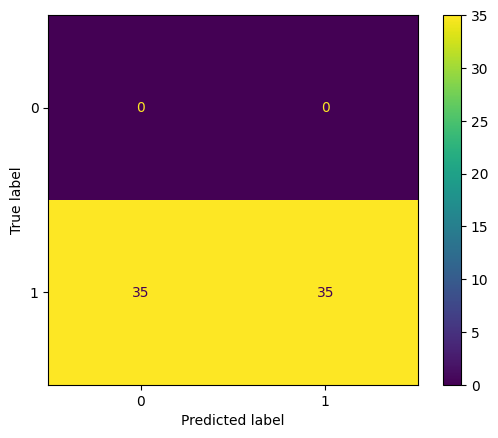

In [24]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score,cohen_kappa_score, accuracy_score, recall_score
from scipy import stats
import matplotlib.pyplot as plt

data = pd.read_csv(f'/home/abdelrahman.sadallah/mbzuai/review_rewrite/chatgpt/main_data/human_chatgpt_filtered_data.csv')
data.rename(columns={'Discard': 'human_discard'}, inplace=True)
data['human_discard'] = data['human_discard'].apply(lambda x: 1 if x == 1.0 else 0)
data['chatgpt_discard'] = data['chatgpt_discard'].astype(int)
data['human_discard'] = data['human_discard'].astype(int)

print(f"Accuracy: {accuracy_score(data['human_discard'], data['chatgpt_discard'])}")
print(f"Recall: {recall_score(data['human_discard'], data['chatgpt_discard'])}")
print(f"F1 Score: {f1_score(data['human_discard'], data['chatgpt_discard'])}")
print(f"Cohen's Kappa: {cohen_kappa_score(data['human_discard'], data['chatgpt_discard'])}")

cm = confusion_matrix(data['human_discard'], data['chatgpt_discard'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
disp.plot()
plt.show()
